
Run the cell below to import the required packages:

In [256]:
%matplotlib inline

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

def accuracy(Y,P):
    return np.count_nonzero(np.equal(np.argmax(Y,axis=-1),np.argmax(P,axis=-1)).astype(int))/float(Y.shape[0])

def visualize(data):
    p = data.reshape((28,28))
    plt.imshow(p,interpolation='none', cmap='gray_r')
    plt.show()


## Dataset


The MNIST dataset contains handwritten digits, it has 60000 train image and 10000 test image. It's a commonly used dataset for training and testing machine learning models, because it contains real word examples, it's not that big, so it's fast to try out learning algorithms and experiment on this. The dataset is a subset of a larger database collected by National Institute of Standards and Technology (NIST) in the 90's. The purpose of collecting the dataset to create a database which can be used to create algorithms to be used in automatic ZIP code reader systems. The numbers in the training set was taken from American Census Bureau:
<img src="images/hwd_example.PNG" width="300px" />

The test set was collected from American high school students. Because train and test data comes from very different sources  it's not well suited for machine learning experiments. This was the reason for creating the MNIST (the images also was normalized to fit into 28x28 pixel and transformed to grayscale). In 2017 a larger dataset (EMNIST) was created from the original data containing 240000 training images and 40000 testing images. 

The cells below will load the data into numpy matrices:

In [258]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))/255.
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))/255.

In [259]:
print(x_train.shape)
print(y_train.shape)
print(y_train[0:10])
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
[5 0 4 1 9 2 1 3 1 4]
(10000, 784)
(10000,)


As you can see, the dataset have 60000 training images and 10000 test images.

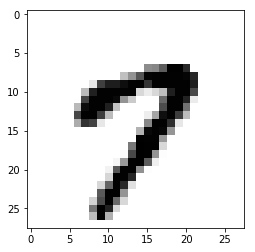

In [260]:
visualize(x_train[15])

The label is simply the number you can see on the picture:

In [261]:
y_train[15]

7

In [262]:
min(y_train), max(y_train)

(0, 9)

## Goal

The goal of this notebook is to implement neural networks in numpy and train it with gradient descent to recognize handwritten digits. 

The notebook contains 2 homeworks: 
* implementing the forward step of an L-layer neural network (due 03.06)
* implementing the backward step of an L-layer neural network, implementing the gradient descent and mini-batch gradient descent (due 03.13)


## One-hot encoding

The labels are discrete variables. To train a classifier we need to transform them to probabilities. This transformation is called one-hot encoding. It is defined as follows:

\begin{equation}
y\in \{0,1,2,...,K\}\longrightarrow y\in \{0,1\}^K \\
y=l \Longrightarrow y = [0, 0, \dots,\underbrace{1}_{l.}, \dots, 0]\; \leftrightarrow (K \mathrm{dimensional}),\;
\end{equation}

Implement this transformation:

In [263]:
#GRADED function
#Don't change the function name, parameters and return values
def one_hot(y):
    """
        Transforms labels to one-hot encoded labels.
        Input: 
            * y:   (M,) contains 0-9 digits
        Output:
            * y_oh: (M, K), K: M dimension, K -> 10
    """
    y_oh = np.zeros( (y.shape[0],10), int )
    ###Start code here
    
    # set y_oh to the one-hot encoded version of labels y
    for i in range( 0, y.shape[0] ):
        y_oh[i][y[i]] = 1.

    ###End code here
    return y_oh

In [264]:
one_hot(y_train)[0:10]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<b>Expected result:</b>
\begin{equation}
\begin{bmatrix}
0.&0.& 0.& 0.& 0.& 1.& 0.& 0.& 0.& 0.\\
1.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.\\
0.& 0.&0.& 0.& 1.& 0.& 0.& 0.& 0.& 0.\\
0.& 1.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.\\
0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 1.\\
0.& 0.& 1.& 0.& 0.& 0.& 0.& 0.& 0.& 0.\\
0.& 1.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.\\
0.& 0.& 0.& 1.& 0.& 0.& 0.& 0.& 0.& 0.\\
0.& 1.& 0.& 0.& 0.& 0.& 0.& 0.& 0.& 0.\\
0.& 0.& 0.& 0.& 1.& 0.& 0.& 0.& 0.& 0.
      \end{bmatrix}
       \end{equation}

<b>Transforming the whole dataset</b>:

In [265]:
y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)

print(y_train_oh.shape)
print(y_test_oh.shape)

(60000, 10)
(10000, 10)


# L layer neural network


Neural network can be described with the following computational graph:
<img src="images/NeuralNetworkForwardPass.png" />

This graph describes the forward propagation in the neural network. As you can see, every linear unit needs a $W$ matrix and a $b$ vector. First we need to initialize the weights of the networks. 


## Initializing the weights of an L layer network

As you can see above the computational graph also shows the dimensions of these objects. It's important to initialize the $W$
matrices to be random. To see this, imagine the following network:

<img src="images/simple_net.png" />

If we initialize the weights to zeros (or each neuron have the same weights), then the network will have the following symmetry: 
\begin{equation}
a^{[1]}_0=a^{[1]}_1
\end{equation}

So the two neurons in the first layer computes exactly the same function in the first step. When we calculate the derivatives with backpropagation, the gradient's will also reflect this symmetry:
\begin{equation}
\frac{\partial L}{\partial W^{[1]}_0}=\frac{\partial L}{\partial W^{[1]}_1}
\end{equation}

This means, that the weights of the first and second neuron will be the same for every iteration when we try to train the network with gradient descent ($W=W-\alpha\frac{\partial L}{\partial W}$). So in case of $n$ neuron, instead of $n$ neuron we will have just one, but we will do the single neuron computation $n$ times. To break this symmetry you need to initialize the $W$ matrices to be random. This will break the symmetry. The $b$ values can be set to zeros.

<b>Takeaway message: </b> to break the symmetry (every neuron in the layer computes the same) you need to initialize the weights matrices ($W$) to be random!


#### Multiplying with a small number


We also want the randomly initialized weight matrix to have small values. If the values of the weight matrix aren't small, then the output of the neuron won't be small either. Because after the linear unit we go trough some non-linearity, and in case of a sigmoid non-linearity it means we are in the flat part of the function:
<img src="images/sigmoid.PNG" />

If we are in the flat part as you can see in the plot, the derivative is pretty small. This means the change in the weight matrix will be very small, so the training will slow down. To avoid this, we multiply the weights with a small number, let's say with $0.01$.

In [266]:
#GRADED function
#Don't change the function name, parameters and return values
def initialize_weights(layer_dimensions):
    """
        Initialize the weights of the neural network.
        Input:
            * layer_dimensions: list containing the number of neurons for each layer. 
                                layer_dimensions[0] is the dimensionality of our data. 
                                layer_dimensions[1] is the number of neurons in the first layer.
        Output:
            * parameters: dict containing the weights of the network.
                          parameters["W1"] = the W weight matrix of the first layer
                          parameters["b1"] = the b bias node of the first layer
    """
    parameters={}
    ###Start code here
    
    for i in range( 1, np.shape(layer_dimensions)[0] ): # indexing the layers
        # dim W: layer_dimensions[i] x layer_dimensions[0]
        parameters['W'+str(i)] = np.random.normal( 0.0, 1.0, [ layer_dimensions[i], layer_dimensions[i-1] ] )*0.01
        parameters['b'+str(i)] = np.zeros( (layer_dimensions[i], 1), float )
            
    # initialize the weight matrix W with small random numbers (multiply by 0.01), and b to zeros FOR ALL LAYERS!

    ###End code here
    return parameters

In [267]:
np.random.seed(0)
parameters = initialize_weights([3,6,4])

In [268]:
print("W1.shape=",parameters["W1"].shape)
print("b1.shape=",parameters["b1"].shape)
print("W1=",parameters["W1"])
print("b1=",parameters["b1"])

W1.shape= (6, 3)
b1.shape= (6, 1)
W1= [[ 0.01764052  0.00400157  0.00978738]
 [ 0.02240893  0.01867558 -0.00977278]
 [ 0.00950088 -0.00151357 -0.00103219]
 [ 0.00410599  0.00144044  0.01454274]
 [ 0.00761038  0.00121675  0.00443863]
 [ 0.00333674  0.01494079 -0.00205158]]
b1= [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [269]:
print("W2.shape=",parameters["W2"].shape)
print("b2.shape=",parameters["b2"].shape)
print("W2=",parameters["W2"])
print("b2=",parameters["b2"])

W2.shape= (4, 6)
b2.shape= (4, 1)
W2= [[ 0.00313068 -0.00854096 -0.0255299   0.00653619  0.00864436 -0.00742165]
 [ 0.02269755 -0.01454366  0.00045759 -0.00187184  0.01532779  0.01469359]
 [ 0.00154947  0.00378163 -0.00887786 -0.01980796 -0.00347912  0.00156349]
 [ 0.01230291  0.0120238  -0.00387327 -0.00302303 -0.01048553 -0.01420018]]
b2= [[0.]
 [0.]
 [0.]
 [0.]]


<b>Expected output:</b>

W1.shape= (6, 3)

b1.shape= (6, 1)

W1=\begin{equation}\begin{bmatrix} 0.01764052&  0.00400157& 0.00978738\\
  0.02240893&  0.01867558 &-0.00977278]\\
  0.00950088& -0.00151357& -0.00103219]\\
  0.00410599&  0.00144044 & 0.01454274]\\
  0.00761038 & 0.00121675&  0.00443863]\\
  0.00333674 & 0.01494079 &-0.00205158]]
 \end{bmatrix}
 \end{equation}
 
b1= \begin{equation}
\begin{bmatrix}0\\
 0.\\
 0.\\
 0.\\
 0.\\
 0.
 \end{bmatrix}
 \end{equation}

## Forward propagation in the network


To evaluate the network and make prediction, calculate the loss function you have to go trough the computational graph shown above. As you can see the graph contains modules. To implement the whole calculation you need to implement these simple modules, step by step.


### Linear step


The first module is the linear unit. The calculation is illustrated in the following graph:
<img src="images/nn_linear.png" />

In [270]:
#GRADED function
#Don't change the function name, parameters and return values
def linear_forward(W, b, a_prev):
    """
        Linear unit in the computational graph.
        Inputs:
                * W: the weight matrix of the unit (dimensions in the graph above)
                * b: the bias vector of the unit (dimensions in the graph above)
                * a_prev: the activation from the previous node (dimensions in the graph above)
        Outputs:
                * Z:     the result (dimensions in the graph above)
                * cache: combination of values you will need in backward passes
    """
    ###Start code here
    
    # Calculate Z
    Z = np.add( np.matmul( W, a_prev ), b )

    # Create a cache for backpropagation, suggestion: (Z, W, a_prev)
    cache = (Z, W, a_prev)
    
    ###End code here
    return Z, cache

In [272]:
np.random.seed(0)
parameters = initialize_weights([3,2])
x = np.random.randn(1,3).T
Z, cache = linear_forward(parameters["W1"],parameters["b1"],x)
print(Z)

[[0.01514415]
 [0.01947252]]


<b>Expected output</b>
\begin{equation}
\begin{bmatrix}0.01514415\\
 0.01947252
    \end{bmatrix}
\end{equation}

### Non-linear step

After we calculated the linear node, the result of this will go trough some non-linearity. This is shown in the graph below:

<img src="images/nn_nonlinear.png" />

We choose the $g$ function to be sigmoid function in this case. Implement this function. The sigmoid function:
$f(x)=\frac{1}{1+e^{-x}}$

In [273]:
#GRADED function
#Don't change the function name, parameters and return values
def activation_forward(Z):
    """
        Activation node on the forward computational graph.
        Inputs:
                Z: the ouput of linear unit
        Outputs:
                a: the activation
    """
    ###Start code here
    def nonlin(p):
        return 1 / ( 1 + np.exp(-p) )
    
    #implement sigmoid activation
    a = nonlin(Z)

    ###End code here
    return a

In [274]:
np.random.seed(0)
Z = np.random.randn(2,3)
activation_forward(Z)

array([[0.85371646, 0.59872543, 0.72685773],
       [0.9038621 , 0.86617546, 0.27343225]])

<b>Expected output:</b>

\begin{equation}
\begin{bmatrix}
0.85371646& 0.59872543& 0.72685773\\
       0.9038621 & 0.86617546& 0.27343225
       \end{bmatrix}
       \end{equation}

### Softmax step

The last part of the computational graph is a softmax unit.

<img src="images/nn_softmax.png" />

Implement the function shown in the graph.

In [275]:
#GRADED function
#Don't change the function name, parameters and return values
def softmax(Z):
    """
        Calculates the softmax of a matrix.
        Input: 
            * Z: (M,K)=(num_examples, num_categories)
        Returns:
            * a: (M,K)=(num_examples, num_categories)
    """
    ###Start code here
    
    def elemwise_soft(p):
        return np.exp(p) / np.sum(np.exp(p), axis=1, keepdims=True )
    
    # Transform Z to probabilites
    # The sum should be on categories!
    a = elemwise_soft(Z)
    
    ###End code here
    return a

In [276]:
np.random.seed(0)
Z = np.random.randn(2,3)
softmax(Z)

array([[0.58423523, 0.14936733, 0.26639744],
       [0.57854881, 0.39829292, 0.02315827]])

<b>Expected output:</b>

\begin{equation}
\begin{bmatrix}
0.58423523& 0.14936733& 0.26639744\\
0.57854881& 0.39829292& 0.02315827
\end{bmatrix}
\end{equation}

### Full network forward step

Congratulations, you implemented all the units of a the computational graph. Now your job is to implement the full network using the units you implemented! So the computation you have to do can be shown with the following computational graph:

<img src="images/nn_forward.png" />

Implement this calculation!

<b>REMEMBER: use the units you implemented above (function calls).<b/>

In [277]:
#GRADED function
#Don't change the function name, parameters and return values
def nn_forward(parameters, X):
    """
        Calculates a forward step in the network.
        Input:
            * parameters: dict of parameters.
                          parameters["W1"]= the W matrix of first layer
                          parameters["b4"]=the bias vector in layer 4
            * X: input matrix. Shape (M,K)
    """
    caches = []
    L = len(parameters)//2
    
    ###Start code here
    
    # Set a_prev to the input!
    # In the first node of the computational graph, the input is transposed!
    a = X.T
    a_prev = a
    
    for i in range(1, L):
        Z, cache = linear_forward( parameters["W" + str(i)], parameters["b" + str(i)], a_prev)
        caches.append( cache )
        a_prev = activation_forward(Z)

    Z, cache = linear_forward( parameters["W" + str(L)], parameters["b" + str(L)], a_prev ) 
    caches.append( cache )
    a = softmax( Z.T )
    
    # Go trough the nodes of the computational graph, from LEFT to RIGHT
    # Always use as the input of current node the ouput of previous node!
    # Get the W, b weights from the parameters dictionary
    # use linear_forward and activation_forward function to step one in the layer
    # append the linear unit's cache to caches list
    
    # Important: the last layer activation should be softmax! 
    # Important: Transpose Z (in the last unit)

    ###End code here
    
    return (a,caches)

In [278]:
np.random.seed(1)
parameters = initialize_weights([3,4,2])
x = np.random.randn(2,3)
AL, cache = nn_forward(parameters, x)
print(AL)

[[0.49967587 0.50032413]
 [0.49966831 0.50033169]]


<b>Expected output:</b>
\begin{equation}
\begin{bmatrix}
0.49970579& 0.50029421\\
0.49971335& 0.50028665
\end{bmatrix}
\end{equation}


HOMEWORK 1 END
<hr style="height:3px" />

## Loss function


To calculate the loss function you have to implement the computation in the following graph:
<img src="images/nn_loss.png" />

In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def crossentropy(P, Y):
    """
        Calculates the crossentropy-loss shown in the computational graph above.
        Inputs:
                * P the prediction of the network (dimensions above)
                * Y the one-hot encoded labels
        Outputs:
                * The crossentropy between the P and Y
    """
    ### Start code here
   
    #calculate the coross entropy loss
    loss = None
    
    ### End code here
    return loss

In [ ]:
np.random.seed(1)
parameters = initialize_weights([3,4,2])
x = np.random.randn(2,3)
AL, cache = nn_forward(parameters, x)
y = np.array(([[0,1],[1,0]]))
crossentropy(AL,y)

<b>Expected output:</b>

0.6931397896985225

## Backward propagation in the network


Congratulations! You implemented a whole L layer neural network for classification problems! 

In the next step you will implement backpropagation to be able to train the network.

In the forward propagation you go trough a computational graph from left to right. In the backpropagation you go trough a computational graph from right to left. 

The computational graph of the backpropagation in $L$ layer neural network is the following.

<img src="images/NeuralNetworkBackwardPassV3.png" />

To implement this, you will firs implement the different units this calculation needs.

### Backpropagation trough non-linearity

### Loss and softmax step (last node on the graph)


Because we go trough on the graph from the right to the left the first node is the $\frac{\partial L}{\partial Z^{[L]}}$ unit.  When we use softmax activation and cross entropy functions the derivate will be simple in the top of the network. Implement this calculation as shown in the computational graph:
<img src="images/nn_softloss_backward.png" />

In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def losssoftmax_backward(P,Y):
    """
        Calculates the dLdZ derivate which is in the top of the network. 
        Inputs:
                * P the prediction of the network
                * Y the labels
        Outputs:
                * dLdZ the derivate of the L loss function 
    """
    ###Start code here
    
    #implement the calculation shown in the graph
    dLdZ = None
    
    ###End code here
    return dLdZ

In [ ]:
np.random.seed(1)
parameters = initialize_weights([3,4,2])
x = np.random.randn(3,3)
AL, cache = nn_forward(parameters, x)
y = np.array(([[0,1],[1,0],[1,0]]))

losssoftmax_backward(AL,y)

<b>Expected output:</b>
\begin{equation}
\begin{bmatrix}
0.1665686 & -0.16676222& -0.16677319\\
       -0.1665686&  0.16676222&  0.16677319
\end{bmatrix}
\end{equation}

### General non-linear backward step in the network

Implement a backward step on non-linearity in the model.  This computation is shown in the following graph:

<img src="images/nn_nonlin_backward.png" />

In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def activation_backward(dLda, cache):
    """
        Calculates the backward step in a non-linearity.
        Inputs:
            * dLda: The derivates above the current unit.
            * cache: The cache from the forward step.
    """
    
    ###Start code here
    
    # Use the cache from the foward step
    # Calculate the g'(Z): the sigmoid derivate (the derivate is: sigmoid(Z)*(1-sigmoid(Z)) )
    # Do the calculation shown in the graph.
    dLdZ = None
    
    ###End code here
    return dLdZ

In [ ]:
np.random.seed(1)
Z      = np.random.randn(4,2)
W      = np.random.randn(4,3)
a_prev = np.random.randn(3,2)
dLda   = np.random.randn(4,2)
    

dLdZ = activation_backward(dLda, (Z, W, a_prev))

dLdZ

<b>Expected output:</b>
\begin{equation}
\begin{bmatrix}
-0.01689878&-0.2133506 \\
       -0.06251018& 0.10071241\\
       -0.14419048& -0.03281763\\
       -0.08698937& -0.18342292
\end{bmatrix}
\end{equation}

### Backpropagation trough linear unit


Implement the backpropagation trough a linear unit. This calculation is shown as the following graph:

<img src="images/nn_linear_backward.png" />

In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def linear_backward(dLdZ, cache):
    """
        Implements the backward step on linear unit as shown in the graph above/
        Inputs: 
                * dLdZ:  the derivate from the next node
                * cache: the cache form froward step
        Returns:
                * dLda
                * dLdW
                * dLdb
    """
    
    ###Start code here
    
    # Use the cache from the forward step
    #Calculate dLda as shown in the graph
    dLda = None
    #Calculate the dLdW shown in the graph
    dLdW = None
    #Calculate the dLdb shown in the graph
    # Use keepdims=True
    dLdb = None
    
    ###End code here
    return (dLda, dLdW, dLdb)

In [ ]:
np.random.seed(1)
parameters = initialize_weights([3,2,2])
x = np.random.randn(3,3)
AL, cache = nn_forward(parameters, x)
y = np.array(([[0,1],[1,0],[1,0]]))

dLdZ=losssoftmax_backward(AL,y)

dLda, dLdW, dLdb = linear_backward(dLdZ, cache[-1])
print("dLda=",dLda)
print("dLdW=",dLdW)
print("dLdb=",dLdb)

<b>Expected output</b>

 \begin{equation}dLda= \begin{bmatrix}0.00238152&-0.00237077& -0.00237088\\
 -0.00085494 & 0.00085108 & 0.00085112
 \end{bmatrix}
 \end{equation}
 \begin{equation}dLdW=\begin{bmatrix}-0.08456424&-0.08032504\\
 0.08456424 & 0.08032504\\
 \end{bmatrix}\end{equation}
 \begin{equation}dLdb=\begin{bmatrix}-0.16553337 \\ 0.16553337\end{bmatrix}\end{equation}

### Backpropagation trough the network


Using the units you already implemented, implement the full backward pass trough the network as shown in the following graph:

<img src="images/NeuralNetworkBackwardPassV3.png" />


In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def nn_backward(X, Y, P, caches):
    """
        Calculates the backward pass for the network as shown in the computational graph above.
        Inputs:
                * X: The input examples: (M,N) = (number_of_examples, dimensionality_of_data)
                * Y: The one-hot encoded labels: (M,K) = (number_of_examples, number_of_categories)
                * P: The network prediction: (M,K)
                * caches: the cache from forward step
        Returns:
                * derivates: dictionary containing all the derivates
                             derivates["dLdW2"] = the derivate of the loss L regarding to the weight matrix W of 2. layer
    """
    derivates = {}
    ###Start code here
    
    # Implement the calculation shown in the graph!
    # The arrows in the graph: the output of a unit is the input of the previous unit
    # IMPORTANT: you have to go trough the graph from RIGHT to LEFT
    
    # The last node derivative (loss) initializes the calculation by setting the derivative in the top of the network
    
    
    # compute the backward pass on non-linearity (use the function you implemented)
    # compute the backward pass on linear unit (use the function you implemented)
    # save the derivates to the derivates dict
    # derivates["dLdW2"] = the derivate of the loss L regarding to the weight matrix W of 2. layer
        
 
        
    ###End code here
    return derivates

In [ ]:
np.random.seed(1)
parameters = initialize_weights([3,2,2])
x = np.random.randn(4,3)
y = (np.random.randn(4,2)>0.5).astype(int)
AL, caches = nn_forward(parameters, x)

nn_backward(x,y, AL, caches)

\begin{equation}
dLdW1 = \begin{bmatrix}
    -6.21632506e-04& -2.36318550e-04&  1.23490272e-03\\
     3.61013616e-04& -1.50058030e-05& -4.73913042e-04
     \end{bmatrix}
\end{equation}
     \begin{equation}
     dLdW2=\begin{bmatrix}
  0.00113032&  0.00250435\\
       0.00110121& -0.00371535
       \end{bmatrix}
       \end{equation}
 \begin{equation}
 dLdb1=\begin{bmatrix}4.25433282e-06& -1.48633758e-06
 \end{bmatrix}\end{equation}
 \begin{equation}
 dLdb2=\begin{bmatrix} 0.00112994&-0.00112994\end{bmatrix}\end{equation}

## Training the network

Congratulation! You implemented the forward and backward calculation of a neural network. Training a network now it's very easy.

### Gradient descent

First, let's implement gradient descent for neural networks. The gradient descent finds the weights of the network using the following algorithm:

```pseudo
for every W,b:
    W = random(W_shape)
    b = random(b_shape)
repeat{
    for every W,b:
        dLdW, dLdb = get_derivatives(X,Y, W, b)
        W = W - alpha * dLdW
        b = b - alpha * dLdb
}
```

In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def nn_train_gd(X, Y, layers, n_iter=1000, lr=0.01):
    """
        Creates and trains a neural network with gradient descent.
        Inputs:
                * X: the images (number_of_examples, 28*28)
                * Y: the labels (number_of_examples, 10)
                * layers: the definition of neural networks
                          [28*28, 100, 10]: two layers, 100 neuron in first layer, and 10 neurons in the last layer
                          the first element of this list must be 28*28
                          the number of neurons in the last layer must be the same as Y.shape[1]
                * n_iter: how many iteration we want with gradient descent
                * lr:     learning rate
        Returns:
                * parameters: the trained parameters of the network
                * losses:     the loss values
    """
    L = len(layers)
    losses = []
    
    ###Start code here
    
    #initialize the weights of the network
    parameters = None
    
    # In one iteration of gradient descent:
      # Do a forward step in the network. Use nn_forward
      # Calculate the derivates doing a backward step in the network. Use nn_backward
      # Update the weights
      # Calculate the loss. Use crossentropy. (and save it to losses)

    
    ###End code here
    return parameters,losses

In [ ]:
# This will take a while
parameters,losses = nn_train_gd(x_train, y_train_oh, [28*28, 100, 10], n_iter=3, lr=0.01)

In [ ]:
P, _ = nn_forward(parameters, x_train)

In [ ]:
accuracy(y_train_oh, P)

### Mini-batch gradient descent

As you can see above, taking one step with gradient descent takes a lot of time, even with this smaller dataset (60k images). In deep learning instead of gradient descent we use mini-batch gradient descent or some more modern version of it. 

In mini-batch gradient descent we don't use the whole dataset in every iteration, instead we use a smaller sample (mini-batch). We iterate trough the dataset with these mini-batches, calculate the derivatives using these mini-batches and do a gradient descent step. After we went trough the dataset (we completed one epoch) we repeat the process for some epochs.

So the mini-batch gradient descent algorithm is the following:
```pseudo
for every W,b:
    W = random(W_shape)
    b = random(b_shape)
repeat{
    for mini_batch_X, mini_batch_Y from X,Y:
        for every W,b:
            dLdW, dLdb = get_derivatives(mini_batch_X, mini_batch_Y, W,b)
            W = W - alpha * dLdW
            b = b - alpha * dLdb
}
```

In [ ]:
#GRADED function
#Don't change the function name, parameters and return values
def nn_train_sgd(X, Y, layers, batch_size=100, epochs=100, lr=0.01):
    """
        Creates and trains a neural network with gradient descent.
        Inputs:
                * X: the images (number_of_examples, 28*28)
                * Y: the labels (number_of_examples, 10)
                * layers: the definition of neural networks
                          [28*28, 100, 10]: two layers, 100 neuron in first layer, and 10 neurons in the last layer
                          the first element of this list must be 28*28
                          the number of neurons in the last layer must be the same as Y.shape[1]
                * n_iter: how many iteration we want
                * lr:     learning rate
        Returns:
                * parameters: the trained parameters of the network
                * losses:     the loss values
    """
   
    losses = []
    
    ###Start code here
    
    #initialize the weights of the network
    parameters = None
    
    # Iterate trough epochs
       # Iterate trough batches in dataset
          # Do a forward step in the network. Just with the mini-batch! Use nn_forward
          # Calculate the derivates doing a backward step in the network. Just for the mini-batch! Use nn_backward
          # Update the weights
       # Calculate the loss. Use crossentropy. Save to losses.



    ###End code here
    return parameters,losses

In [ ]:
parameters,losses = nn_train_sgd(x_train, y_train_oh, [28*28, 100, 10], batch_size=100, epochs=20, lr=0.01)

In [ ]:
plt.plot(losses)

<b>Expected output</b>

Decreasing loss function.

### Accuracy

In [ ]:
P, _ = nn_forward(parameters, x_train)

In [ ]:
accuracy(y_train_oh, P)

<b>Expected accuracy:</b> around 0.88 (88%)

### Test accuracy

To measure the performance of the algorithm we use a test_set

In [ ]:
P, _ = nn_forward(parameters, x_test)
accuracy(y_test_oh, P)

In [ ]:
i=6
visualize(x_test[i])
print("Network predicts: ", np.argmax(P[i,:]))